In [1]:
import pandas as pd
import numpy as np
import zipfile
import pprint
import csv
from time import time
import visuals as vs
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

# Core Functions

In [2]:
def explore_country(points):
    pnts=points
    pnts = points[['water_source','water_tech','status_id','pay','management','installer','install_year','status','source','adm1','adm2','report_date','lat_deg','lon_deg']]
    #does using this copy cause problems?
    for col in ['water_source','water_tech','installer', 'management']:
        try:
            pnts = pnts.assign(**{col: pnts[col].str.upper()})
        except AttributeError:
            continue
    Complete = pnts.count()*100/len(pnts)
    Unique_count = pnts.nunique()
    Types = pnts.dtypes
    df = pd.DataFrame([Types,Complete,Unique_count], columns = Complete.index)
    df.index = ['Type','Completeness','Unique']
    n_func = np.sum(pnts['status_id']=='yes')
    print("Found {} water points, of which {:.0f}% are functional".format(len(pnts), n_func*100/len(pnts)))
    return pnts, df


In [3]:
def transform_country(features_raw):
    """Drops unnecessary features and fills null values"""
    
    features_raw = features_raw.assign(status_id = features_raw['status_id'].replace('unknown', np.nan))
    features_raw = features_raw.dropna(subset = ['install_year','status_id'])
    features_raw = features_raw.assign(install_year = features_raw['install_year'].astype('int'))
    report_year = features_raw['report_date'].str.slice(0,4).astype('int')
    age_years = report_year - features_raw['install_year']
    features_raw = features_raw.assign(age_years = age_years.values)     
    features_valid = features_raw[features_raw.age_years > 0]
    features_valid = features_valid[features_valid.age_years < 100]
    status = features_valid['status_id'].map({"yes":0, "no":1}).astype('int')  
    features_final = features_valid.drop(['status_id','source','status','adm2','report_date','lat_deg','lon_deg'], axis = 1)
    features_final = features_final.fillna('NOT RECORDED')
    not_recorded = ["None Not recorded",'not recorded','NONE','None', 'Unknown',":Don't know",'#NAME?','UNIDENTIFIED','9999 - Unknown','999 - Unknown','0',' ']
    features_final = features_final.replace(not_recorded, 'NOT RECORDED')  
    features_final = features_final.replace('PRIVATE OPERATOR', 'PRIVATE OPERATOR/DELEGATED MANAGEMENT')
    features_final = features_final.replace(['GOVERNMENT OPERATION',"DIRECT GOVERNMENT OPERATION?,"], 'DIRECT GOVERNMENT OPERATION')
    features_final = features_final.replace('COMMUNITY  MANAGEMENT', 'COMMUNITY MANAGEMENT')


    return features_final, status


In [4]:
def reclassify(df, col, min_count):
    """ If there aren't enough instances of a feature for it to be useful, set it to )ther"""
    unique_list = df[col].value_counts()
    other = unique_list[unique_list < min_count].index.tolist()
    other.extend(["None Other",  "Other Other",  'other', 'Other','OTHER OTHER'])
    col_new = df[col].replace(other, 'OTHER')
    df_new = df.assign(**{col: col_new.values}) 
    return df_new 

In [97]:
def reclass_pay(df):
    """Reduces the number of classes in 'Pay' column by combining similar concepts"""
    col = df.loc[:,'pay']
    no = ['No water committee', 'No ','Never pay','No payment ? its free','Never','No- water is free','No payment – its free','0',0,'No','FALSE','No payment system']
    breakdown = ['Yes but only in case of breakdown', 'Only if there is a breakdown','Pay when scheme fails','Only after system breakdown']
    other = ['Not recorded','Unkown','Don\'t Know','OTHER:','Other','OTHER:No idea as for now']
    col = col.replace(no, 'No')
    col = col.replace(breakdown, 'On Breakdown')
    col = col.replace(other, 'NOT RECORDED')
    col.value_counts()
    col[(col!='On Breakdown') & (col!='No') & (col != 'NOT RECORDED') & (col != 'No water') & (col.isna() == False)] = 'Yes'
    
    # meaning of 'No water committee' is unclear 
    
    df = df.assign(pay = col.values)
    
    return df


In [92]:
def encode_country(df):
    features_final = pd.get_dummies(df)

    encoded = list(features_final.columns)
    print("{} total features after one-hot encoding.".format(len(encoded)))
    
    return features_final

In [7]:
def predict_custom(clf, points, thresh):
    prob = clf.predict_proba(points)
    prob[prob >= thresh] = 1
    prob[prob < (1-thresh)] = 0
    prediction = [p[1] for p in prob]
    return prediction

In [8]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    #predictions_test = learner.predict(X_test)
    #predictions_train = learner.predict(X_train[:300])
    predictions_train = predict_custom(learner, X_train[:300], .2)
    predictions_test = predict_custom(learner, X_test, .2)
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, 2)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] =  fbeta_score(y_test, predictions_test, 2)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    cnf_matrix = confusion_matrix(y_test, predictions_test)
    importances = importance_sum(learner, X_test.columns)

    # Return the results
    return results, cnf_matrix, importances

In [9]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [58]:
def importance_sum(classifier, columns):   
    try:
        f_imp = pd.DataFrame(data=classifier.feature_importances_, index = columns, columns=['imp'])
    except:
        return None
    a = [x.split('_') for x in f_imp.index.values]
    for i, feat in enumerate(a):
        if feat[0] in ['installer','management','pay','adm1']:
            a[i] = feat[0]
        else:
            a[i] = " ".join(feat[0:2])
    f_imp= f_imp.assign(feat = a)
    df = f_imp.pivot_table(values='imp', aggfunc='sum', columns='feat') #,index=None)
    return df

# Data Exploration

In [11]:
#data = zipfile.ZipFile('Data.zip')

In [12]:
#points = pd.read_csv(r'C:\Users\dani0000\Documents\getf\Data\Tanzania.csv', sep=',\s*', skipinitialspace=True, quoting=csv.QUOTE_ALL, engine='python')

In [85]:
pnts_sz = pd.read_csv(r'C:\Users\dani0000\Documents\getf\Data\Swaziland.txt', sep='\t',index_col = 'wpdx_id')
pnts_sz = pnts_sz.assign(pay =  pnts_sz['pay'].astype(np.object))
points_sz, summary = explore_country(pnts_sz)
summary

Found 23784 water points, of which 84% are functional


,water_source,water_tech,status_id,pay,management,installer,install_year,status,source,adm1,adm2,report_date,lat_deg,lon_deg
Type,object,object,object,object,object,float64,int64,object,object,object,object,object,float64,float64
Completeness,100,100,100,100,35.793,0,100,21.977,100,100,100,100,100,100
Unique,11,13,2,117,4,0,51,23,1,5,53,204,10601,8414


In [80]:
pnts_af = pd.read_csv(r'C:\Users\dani0000\Documents\getf\Data\Afghanistan.txt', sep='\t',index_col = 'wpdx_id')
points_af, summary = explore_country(pnts_af)
summary

Found 59849 water points, of which 70% are functional


,water_source,water_tech,status_id,pay,management,installer,install_year,status,source,adm1,adm2,report_date,lat_deg,lon_deg
Type,object,object,object,float64,float64,object,float64,object,object,object,object,object,float64,float64
Completeness,50.2247,85.1058,100,0,0,90.4192,91.5888,69.6119,100,100,100,100,100,100
Unique,7,9,3,0,0,297,32,100,1,39,320,2393,26520,33921


In [15]:
pnts_tz = pd.read_csv(r'C:\Users\dani0000\Documents\getf\Data\Tanzania.txt', sep='\t', index_col = 'wpdx_id')
points_tz, summary = explore_country(pnts_tz)
summary

Found 23478 water points, of which 56% are functional


,water_source,water_tech,status_id,pay,management,installer,install_year,status,source,adm1,adm2,report_date,lat_deg,lon_deg
Type,object,object,object,object,float64,object,float64,object,object,object,object,object,float64,float64
Completeness,99.787,99.5996,100,99.3441,0,99.2504,97.9768,99.4633,100,99.293,99.6507,100,100,100
Unique,20,141,3,15,0,467,76,2683,9,33,50,626,22695,18564


In [16]:
pnts_lb = pd.read_csv(r'C:\Users\dani0000\Documents\getf\Data\Liberia.txt', sep='\t',index_col = 'wpdx_id')
points_lb, summary = explore_country(pnts_lb)
summary

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5,9,11,12,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Found 34281 water points, of which 66% are functional


,water_source,water_tech,status_id,pay,management,installer,install_year,status,source,adm1,adm2,report_date,lat_deg,lon_deg
Type,object,object,object,object,object,object,float64,object,object,object,object,object,float64,float64
Completeness,91.2838,79.4259,100,63.2304,22.0851,75.2108,29.5586,29.0248,100,31.2243,28.4414,100,100,100
Unique,24,118,3,12,5,2113,47,654,3,16,125,788,28333,19843


In [17]:
pnts_sl = pd.read_csv(r'C:\Users\dani0000\Documents\getf\Data\Sierra Leone.txt', sep='\t',index_col = 'wpdx_id')
points_sl, summary = explore_country(pnts_sl)
summary

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Found 54864 water points, of which 77% are functional


,water_source,water_tech,status_id,pay,management,installer,install_year,status,source,adm1,adm2,report_date,lat_deg,lon_deg
Type,object,object,object,object,object,object,float64,object,object,object,object,object,float64,float64
Completeness,100,84.5217,100,86.3863,48.9629,91.0433,89.8312,99.8451,100,99.8432,99.805,100,100,100
Unique,90,153,2,59,6,2194,76,3864,3,23,145,339,42588,18505


In [18]:
pnts_ug = pd.read_csv(r'C:\Users\dani0000\Documents\getf\Data\Uganda.txt', sep='\t',index_col = 'wpdx_id')
points_ug, summary = explore_country(pnts_ug)
summary

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,7,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Found 114722 water points, of which 78% are functional


,water_source,water_tech,status_id,pay,management,installer,install_year,status,source,adm1,adm2,report_date,lat_deg,lon_deg
Type,object,object,object,object,object,object,float64,object,object,object,object,object,float64,float64
Completeness,13.3662,88.5706,100,35.0081,87.468,1.78867,84.6411,88.3161,100,89.8529,89.8529,100,100,100
Unique,52,91,3,173,12,274,87,8601,14,129,269,1153,104346,42646


In [19]:
pnts_zw = pd.read_csv(r'C:\Users\dani0000\Documents\getf\Data\Zimbabwe.txt', sep='\t',index_col = 'wpdx_id')
points_zw, summary = explore_country(pnts_zw)
summary

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Found 38785 water points, of which 61% are functional


,water_source,water_tech,status_id,pay,management,installer,install_year,status,source,adm1,adm2,report_date,lat_deg,lon_deg
Type,object,object,object,float64,object,float64,float64,object,object,object,object,object,float64,float64
Completeness,99.9587,100,100,0,0.0412531,0,77.8497,83.9809,100,99.5179,99.5179,100,100,100
Unique,31,18,3,0,1,0,131,4,3,6,45,875,26294,26702


In [20]:
pnts_all = pd.concat([pnts_af,pnts_lb,pnts_sl,pnts_sz,pnts_tz,pnts_ug,pnts_zw])
points_all, summary = explore_country(pnts_all)
summary

Found 349763 water points, of which 72% are functional


,water_source,water_tech,status_id,pay,management,installer,install_year,status,source,adm1,adm2,report_date,lat_deg,lon_deg
Type,object,object,object,object,object,object,float64,object,object,object,object,object,float64,float64
Completeness,62.1938,89.2313,100,44.6991,40.9729,44.3735,82.4318,76.8692,100,89.8054,89.5506,100,100,100
Unique,196,514,3,372,13,5239,131,15925,28,251,1007,4269,260613,137612


In [21]:
features, status = transform_country(points_all)

features = reclassify(features, 'installer', 50)
features = reclassify(features, 'water_tech', 50)
features = reclassify(features, 'water_source', 100)
features = reclass_pay(features)


features_encoded = encode_country(features)
print("{} data points to learn from".format(len(features)))

549 total features after one-hot encoding.
252814 data points to learn from


In [22]:
feat_all = set(features_encoded.columns)

**Features in order of importance**

yes        0.724699
no         0.214185
unknown    0.061116
Name: status_id, dtype: float64


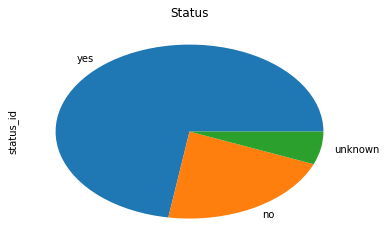

In [23]:
print(points_all['status_id'].value_counts() / 349763  )
ax = points_all['status_id'].value_counts().plot.pie(title='Status')



0    192265
1     60549
Name: status_id, dtype: int64


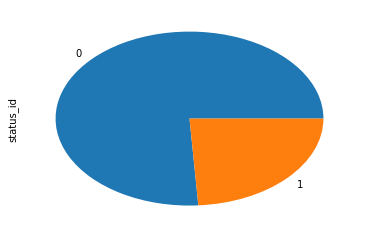

In [24]:
print(status.value_counts())
status.value_counts().plot.pie()


90% of values are between:
1979.0
2012.0


count    252814.000000
mean       2000.193280
std          11.628544
min        1915.000000
25%        1995.000000
50%        2003.000000
75%        2008.000000
max        2017.000000
Name: install_year, dtype: float64

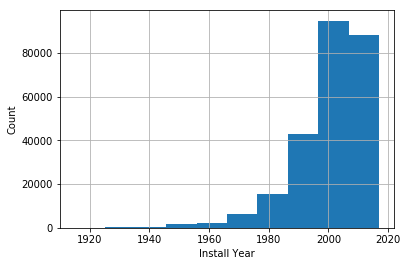

In [25]:
ax = features.install_year.hist()
ax.set(xlabel="Install Year", ylabel="Count")
print("90% of values are between:")
print(features.install_year.quantile(.05))
print(features.install_year.quantile(.95))
features.install_year.describe()

90% of values are between:
1.0
33.0


count    252814.000000
mean         11.193949
std          12.002291
min           1.000000
25%           3.000000
50%           7.000000
75%          15.000000
max          99.000000
Name: age_years, dtype: float64

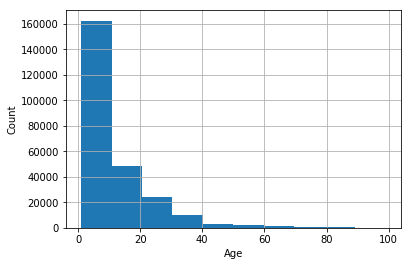

In [26]:
ax = features.age_years.hist()
ax.set(xlabel="Age", ylabel="Count")
print("90% of values are between:")
print(features.age_years.quantile(.05))
print(features.age_years.quantile(.95))
features.age_years.describe()
#reclass negative numbers

In [27]:
negative = features[features.age_years < 0]
positive = features[features.age_years > 100]
print(len(negative))
print(len(positive))
#negative.join(pnts_all, on=features.index)

0
0


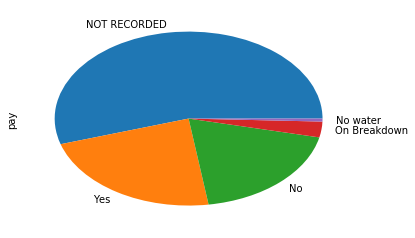

In [28]:
features['pay'].value_counts().plot.pie()

<function matplotlib.pyplot.show(*args, **kw)>

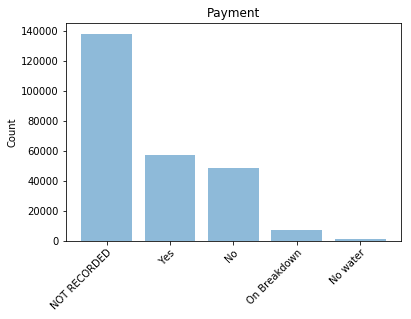

In [29]:
p = features.pay.value_counts()
p_list = p.index.tolist()
a = np.arange(len(p))
plt.bar(a, p.tolist(), align='center', alpha=0.5)
plt.xticks(a, p_list, rotation=45, rotation_mode="anchor", horizontalalignment='right')
plt.ylabel("Count")
plt.title('Payment')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

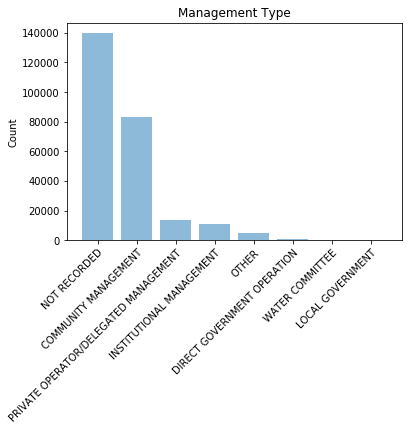

In [30]:
manage = features.management.value_counts()
manage_list = manage.index.tolist()
a = np.arange(len(manage))
plt.bar(a, manage.tolist(), align='center', alpha=0.5)
plt.xticks(a, manage_list, rotation=45, rotation_mode="anchor", horizontalalignment='right')
plt.title('Management Type')
plt.ylabel("Count")    
plt.show

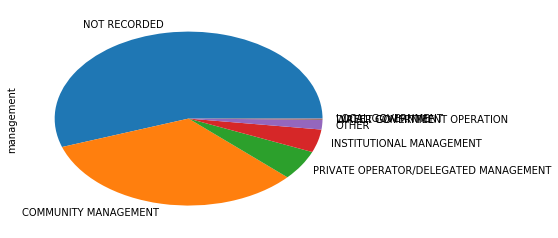

In [31]:
features.management.value_counts().plot.pie()

In [32]:
ws = points_all['water_source'].value_counts()
print("{:.2%} of water sources have more than 100 records".format(len(ws[ws>100])/len(ws)))
tech = features.water_source.value_counts()
tech_list = tech.index.tolist()


32.14% of water sources have more than 100 records


In [33]:
features.management.value_counts().index

Index(['NOT RECORDED', 'COMMUNITY MANAGEMENT',
       'PRIVATE OPERATOR/DELEGATED MANAGEMENT', 'INSTITUTIONAL MANAGEMENT',
       'OTHER', 'DIRECT GOVERNMENT OPERATION', 'WATER COMMITTEE',
       'LOCAL GOVERNMENT'],
      dtype='object')

<function matplotlib.pyplot.show(*args, **kw)>

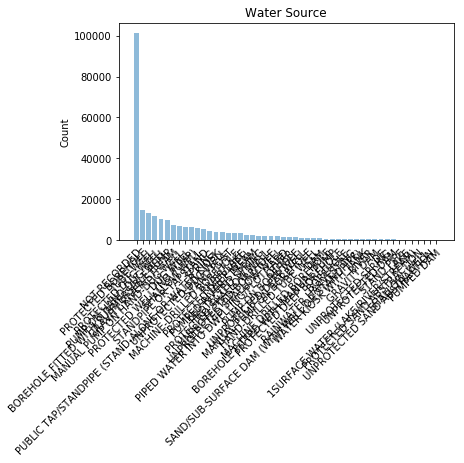

In [34]:

a = np.arange(len(tech))
plt.bar(a, tech.tolist(), align='center', alpha=0.5)
plt.xticks(a, tech_list, rotation=45, rotation_mode="anchor", horizontalalignment='right')
plt.title ('Water Source')
plt.ylabel("Count")
plt.figure(figsize=(20, 3)) 
plt.show

100.00% of water technologies have more than 100 records


<function matplotlib.pyplot.show(*args, **kw)>

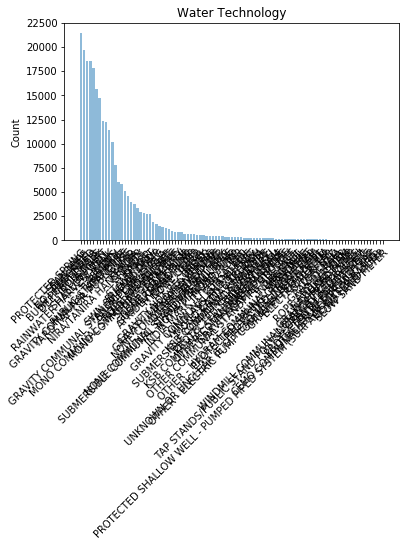

In [35]:
# tech = points_all['water_tech'].value_counts()
print("{:.2%} of water technologies have more than 100 records".format(len(tech[tech>100])/len(tech)))
tech = features.water_tech.value_counts()
tech_list = tech.index.tolist()
a = np.arange(len(tech))
plt.bar(a, tech.tolist(), align='center', alpha=0.5)
plt.xticks(a, tech_list, rotation=45, rotation_mode="anchor", horizontalalignment='right')
plt.title('Water Technology')
plt.ylabel("Count")
plt.show

8.09% of installers have built more than 50 water points


<function matplotlib.pyplot.show(*args, **kw)>

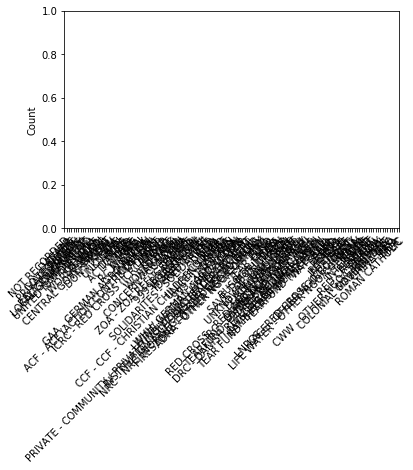

In [36]:
tech = points_all['installer'].value_counts()
print("{:.2%} of installers have built more than 50 water points".format(len(tech[tech>12])/len(tech)))
inst = features.installer.value_counts()
inst_list = inst.index.tolist()
a = np.arange(len(inst))
plt.xticks(a, inst_list, rotation=45, rotation_mode="anchor", horizontalalignment='right')
plt.ylabel("Count")
plt.show

# **Run the Model**

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_encoded, 
                                                    status, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 202251 samples.
Testing set has 50563 samples.


**Benchmark model**

In [38]:
def predictions(age):
    x = features.loc[:,'age_years'].copy()
    x[x < age] = 0
    x[x >= age] = 1
    df = features.assign(age_years = x)
    return df['age_years']
     

In [39]:
F05=[fbeta_score(status, predictions(x), .5) for x in range(1,20)]
F1=[fbeta_score(status, predictions(x), 1) for x in range(1,20)]
F15=[fbeta_score(status, predictions(x), 1.5) for x in range(1,20)]
F2=[fbeta_score(status, predictions(x), 2) for x in range(1,20)]
FA=[accuracy_score(status, predictions(x)) for x in range(1,20)]
#FR=[recall_score(status, predictions(x)) for x in range(1,20)]
FP=[precision_score(status, predictions(x)) for x in range(1,20)]

In [40]:
features_raw = points_all.dropna(subset = ['install_year','status_id'])
features_raw = features_raw.assign(install_year = features_raw['install_year'].astype('int'))
report_year = features_raw['report_date'].str.slice(0,4).astype('int')
age_years = report_year - features_raw['install_year']
features_raw = features_raw.assign(age_years = age_years.values)     
features_valid = features_raw[features_raw.age_years > 0]
features_valid = features_valid[features_valid.age_years < 100]
age_years = features_valid[features_valid.status_id=='no'].age_years

print ("Cutoff Age: {}".format(age_years.median()))
print ("Accuracy is: {}".format(FA[9]))
print ("F2 Score is: {}".format(F2[9]))
print ("Precision  is: {}".format(FP[9]))

Cutoff Age: 9.0
Accuracy is: 0.5959361427769032
F2 Score is: 0.4183170495554969
Precision  is: 0.28909909361883324


In [41]:
df = pd.DataFrame(columns = range(0,19), index = [0.5,1,1.5,2,'Acc','FP'], data = [F05,F1,F15,F2,FA,FP]).transpose()

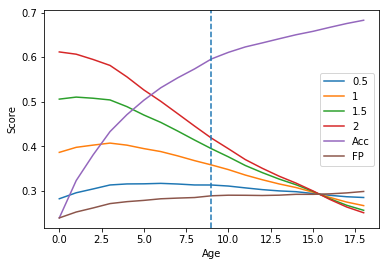

In [42]:
ax = df.plot()

ax.set(xlabel="Age", ylabel="Score")
ax.axvline(x=9, ls ='--')

**Model Selection**


In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


# TODO: Initialize the three models
clf_A = AdaBoostClassifier()
clf_B = LogisticRegression(random_state=42)
clf_C = DecisionTreeClassifier(random_state=42)

samples_100 = len(y_train)
samples_10 = int(samples_100*.1)
samples_1 = int(samples_100*.01)

results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)[0]


#vs.evaluate(results, 60, 40)

AdaBoostClassifier trained on 2022 samples.
AdaBoostClassifier trained on 20225 samples.
AdaBoostClassifier trained on 202251 samples.
LogisticRegression trained on 2022 samples.
LogisticRegression trained on 20225 samples.
LogisticRegression trained on 202251 samples.
DecisionTreeClassifier trained on 2022 samples.
DecisionTreeClassifier trained on 20225 samples.
DecisionTreeClassifier trained on 202251 samples.


In [44]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

clf = DecisionTreeClassifier(random_state=42)
#clf=RandomForestClassifier(random_state=42)

parameters = {'max_depth':(50,100,150,70), 'min_samples_split':(2,5,20)}

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between  
        true and predicted values based on the metric chosen. """

    score = fbeta_score(y_true, y_predict, 2)
    
    return score

scorer = make_scorer(performance_metric)

cv_sets = ShuffleSplit(n_splits = 12, test_size = 0.20, random_state = 42)
grid_obj = GridSearchCV(estimator = clf, param_grid=parameters, scoring=scorer, cv = cv_sets)

grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_
print (best_clf)

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
#best_predictions = best_clf.predict(X_test)
best_predictions =  predict_custom(best_clf, X_test, .2)


# Report the before-and-afterscores
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 2)))
print ("Precision score on the testing data: {:.4f}".format(precision_score(y_test, predictions)))
print ("Recall F-score on the testing data: {:.4f}".format(recall_score(y_test, predictions)))
print ("\nOptimized Model\n------" )
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 2)))
print ("Precision score on the testing data: {:.4f}".format(precision_score(y_test, best_predictions)))
print ("Recall F-score on the testing data: {:.4f}".format(recall_score(y_test, best_predictions)))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=150,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
Unoptimized model
------
Accuracy score on testing data: 0.8264
F-score on testing data: 0.5169
Precision score on the testing data: 0.6967
Recall F-score on the testing data: 0.4855

Optimized Model
------
Final accuracy score on the testing data: 0.7419
Final F-score on the testing data: 0.6677
Precision score on the testing data: 0.4748
Recall F-score on the testing data: 0.7431


In [45]:
global_clf =  best_clf

In [61]:
importance_sum(global_clf, X_train.columns)

feat,adm1,age years,install year,installer,management,pay,water source,water tech
imp,0.216159,0.11219,0.150601,0.068052,0.037803,0.080465,0.206229,0.128501


**Individual Countries**

In [56]:
def local_fit(points):
    features, status = transform_country(points)

    features = reclassify(features, 'installer', 50)
    features = reclassify(features, 'water_tech', 50)
    features = reclassify(features, 'water_source', 100)
    features = reclass_pay(features)

    features_encoded = encode_country(features)



    print("{} data points to learn from".format(len(features)))

    X_train, X_test, y_train, y_test = train_test_split(features_encoded, 
                                                    status, 
                                                    test_size = 0.2, 
                                                    random_state = 42)
    
    # Show the results of the split
    print ("Training set has {} samples.".format(X_train.shape[0]))
    print ("Testing set has {} samples.".format(X_test.shape[0]))
    print ("{:.0f}% of water points are broken.".format(len(status[status==1])*100/len(status)))


    clf = DecisionTreeClassifier(random_state=42)
    features_set = set(features_encoded.columns)
    results_local, c_matrix, importances = train_predict(clf, X_train.shape[0], X_train, y_train, X_test, y_test)
    
    print ("Accuracy score with local classifier: {:.4f}".format(results_local['acc_test']))      #0.5332
    print ("F2-score with local classifier: {:.4f}".format(results_local['f_test']))     #0.2651
    print(importances)
    

    
    diff = feat_all.difference(features_set)
    for col in diff:
        features_encoded = features_encoded.assign(**{col: 0})
    #results_global = global_clf.predict(features_encoded)   #it's seen some of these points before
    results_global = predict_custom(global_clf, features_encoded, .2)
    #print ("{:.0f}% of water points are predicted to be broken.".format(len(results_global[results_global==1])*100/len(results_global)))
    print ("Accuracy score with global classifier: {:.4f}".format(accuracy_score(status, results_global)))     
    print ("F2-score with global classifier: {:.4f}".format(fbeta_score(status, results_global, beta = 2)))   
    print ("F-score with global classifier: {:.4f}".format(fbeta_score(status, results_global, beta = 1)))
    print ("Precision with global classifier: {:.4f}".format(precision_score(status, results_global)))
    
    plot_confusion_matrix(c_matrix, classes=['Functional','Broken'],
                      title='Confusion Matrix')
    return results_local, results_global

78 total features after one-hot encoding.
51284 data points to learn from
Training set has 41027 samples.
Testing set has 10257 samples.
26% of water points are broken.
DecisionTreeClassifier trained on 41027 samples.
Accuracy score with local classifier: 0.6817
F2-score with local classifier: 0.6808
feat      adm1  age years  install year  installer  management  pay  \
imp   0.210124     0.1145      0.135942   0.120488         0.0  0.0   

feat  water source  water tech  
imp       0.237314    0.181632  
Accuracy score with global classifier: 0.5605
F2-score with global classifier: 0.4210
F-score with global classifier: 0.3616
Precision with global classifier: 0.2928
Normalized confusion matrix


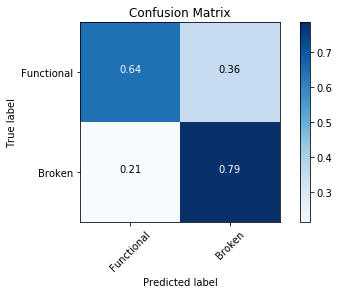

In [60]:
results_af_local, results_af_global = local_fit(points_af)  

146 total features after one-hot encoding.
22118 data points to learn from
Training set has 17694 samples.
Testing set has 4424 samples.
44% of water points are broken.
DecisionTreeClassifier trained on 17694 samples.
Accuracy score with local classifier: 0.7231
F2-score with local classifier: 0.7848
feat      adm1  age years  install year  installer  management       pay  \
imp   0.126009   0.113703      0.221317   0.140928         0.0  0.062217   

feat  water source  water tech  
imp       0.070065    0.265761  
Accuracy score with global classifier: 0.4849
F2-score with global classifier: 0.3906
F-score with global classifier: 0.3972
Precision with global classifier: 0.4088
Normalized confusion matrix


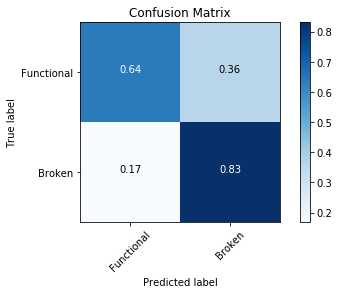

In [59]:
results_tz_local, results_tz_global = local_fit(points_tz)    #local run 1: 0.7742 0.6997       Global run 1: 0.5332 02651

114 total features after one-hot encoding.
47220 data points to learn from
Training set has 37776 samples.
Testing set has 9444 samples.
20% of water points are broken.
DecisionTreeClassifier trained on 37776 samples.
Accuracy score with local classifier: 0.8900
F2-score with local classifier: 0.8096
feat  age years  install year  installer  water source  water tech
imp    0.045206      0.037254   0.871568      0.021371    0.024601
Accuracy score with global classifier: 0.6096
F2-score with global classifier: 0.2149
F-score with global classifier: 0.1939
Precision with global classifier: 0.1667
Normalized confusion matrix


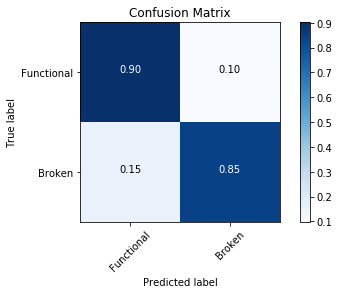

In [50]:
results_sl_local, results_sl_global = local_fit(points_sl)  

68 total features after one-hot encoding.
8505 data points to learn from
Training set has 6804 samples.
Testing set has 1701 samples.
25% of water points are broken.
DecisionTreeClassifier trained on 6804 samples.
Accuracy score with local classifier: 0.5926
F2-score with local classifier: 0.4889
feat  age years  install year  installer  water source  water tech
imp    0.130917      0.122243   0.566592      0.060067    0.120181
Accuracy score with global classifier: 0.5211
F2-score with global classifier: 0.4568
F-score with global classifier: 0.3621
Precision with global classifier: 0.2691
Normalized confusion matrix


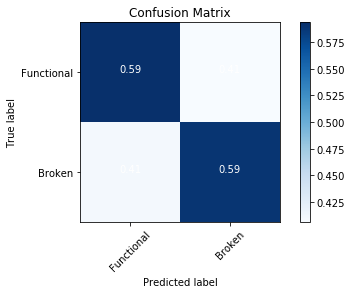

In [51]:
results_lb_local, results_lb_global = local_fit(points_lb)  

169 total features after one-hot encoding.
75786 data points to learn from
Training set has 60628 samples.
Testing set has 15158 samples.
22% of water points are broken.
DecisionTreeClassifier trained on 60628 samples.
Accuracy score with local classifier: 0.7018
F2-score with local classifier: 0.5691
feat  age years  install year  installer  water source  water tech
imp    0.151195      0.182823   0.514214      0.006478     0.14529
Accuracy score with global classifier: 0.7127
F2-score with global classifier: 0.2206
F-score with global classifier: 0.2397
Precision with global classifier: 0.2802
Normalized confusion matrix


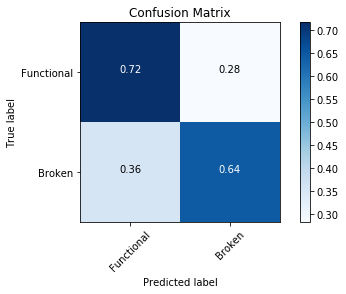

In [52]:
results_ug_local, results_ug_global = local_fit(points_ug)  

37 total features after one-hot encoding.
24932 data points to learn from
Training set has 19945 samples.
Testing set has 4987 samples.
23% of water points are broken.
DecisionTreeClassifier trained on 19945 samples.
Accuracy score with local classifier: 0.6288
F2-score with local classifier: 0.5048
feat  age years  install year  installer  water source  water tech
imp    0.289021      0.248906   0.148937      0.117982    0.195153
Accuracy score with global classifier: 0.6391
F2-score with global classifier: 0.3145
F-score with global classifier: 0.2960
Precision with global classifier: 0.2696
Normalized confusion matrix


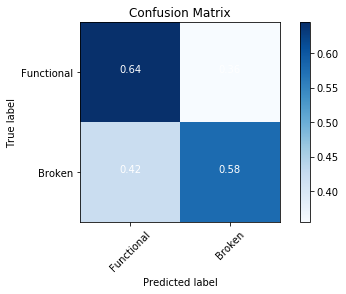

In [53]:
results_zw_local, results_zw_global = local_fit(points_zw)  

33 total features after one-hot encoding.
22969 data points to learn from
Training set has 18375 samples.
Testing set has 4594 samples.
15% of water points are broken.
DecisionTreeClassifier trained on 18375 samples.
Accuracy score with local classifier: 0.9227
F2-score with local classifier: 0.8464
feat     adm1  age years  install year  installer  management       pay  \
imp   0.18405   0.317096      0.195654        0.0    0.076693  0.050048   

feat  water source  water tech  
imp       0.124571    0.051889  
Accuracy score with global classifier: 0.5734
F2-score with global classifier: 0.2801
F-score with global classifier: 0.2076
Precision with global classifier: 0.1451
Normalized confusion matrix


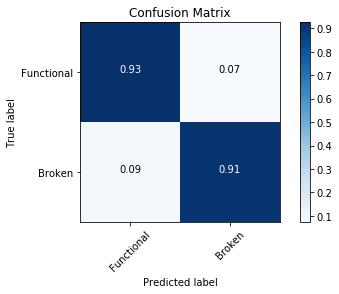

In [98]:
results_sz_local, results_sz_global = local_fit(points_sz)  